#### 0. Imports 

In [4]:
from io import open
import glob
import unicodedata
import string
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import random

#### 1. Load words

In [ ]:
clean_data_path = 'data/dobre-slowa.txt'

In [5]:
all_words = np.asarray(pd.read_csv(clean_data_path, sep=" ", header=None).T)
all_words = all_words.reshape(-1,)
print("The shape of this dataset is ",np.shape(all_words))

The shape of this dataset is  (1164,)


In [119]:
all_words = np.array([word for word in all_words if type(word) is str]).T
all_letters = "".join((set(str(set(list(set(all_words)))))))
n_letters = len(all_letters) + 1 # Plus EOS marker


In [120]:
all_letters

"ŁS£EYĄÓU}W{GKŚFŻŹ-ÒML'HĘPADRJTŃOCIBN ,ZĆ"

In [121]:
# all_letters = ""

# for ch in all_words:
#     if ch in all_letters:
#         pass
#     else:
#         all_letters+=ch
# # all_letters = [for ch in _all_words if ch is not in all_letters]

In [122]:
# remove_chars_list = [",","-","£","Ò","[","]"]

# for ch in remove_chars_list:
#         all_letters.remove(ch)      
        
# n_letters = len(all_letters)

In [123]:
# # check that all words use characters within the range I defined [all_letters]


# for _, word in enumerate(all_words, 0):
# #     print(n, word)
#     i = _
#     if type(word) == str:
#         all_words = np.delete(word, i, 0)
#         i+=1

In [124]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, input, hidden):
#         input_combined = torch.cat((input, hidden))
#         input_combined = torch.cat((input, hidden), 1)

#         hidden = self.i2h(input_combined)
#         output = self.i2o(input_combined)
#         output_combined = torch.cat((hidden, output), 1)
#         output = self.o2o(output_combined)
#         output = self.dropout(output)
#         output = self.softmax(output)
#         return output, hidden

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [125]:
def inputTensor(word):
    '''
    Creates a tensor of shape len(word), 1, n_letters 
    that one-hot encodes letters of each word'''
    tensor = torch.zeros(len(word),1,n_letters)
    
    for n, letter in enumerate(word):
        tensor[n][0][all_letters.find(letter)] = 1
    
    return tensor

#test
# inputTensor("abc")

In [126]:
# word = "abc"

# tensor = np.zeros([len(word),n_letters])

# for n, letter in enumerate(word):
#     tensor[n][all_letters.find(letter)] = 1

# tensor

In [127]:
inputTensor("abc")



(0 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 38 to 40 
    0   0   1

(1 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 38 to 40 
    0   0   1

(2 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 38 to 40 
    0   0   1
[torch.FloatTensor of size 3x1x41]

In [128]:
def targetTensor(word):
    letter_indexes = [all_letters.find(word[li]) for li in range(1, len(word))] # finds the index of each letter of a word and puts it in a list 
    letter_indexes.append(n_letters - 1) # adds EOS character at the end so the network can learn where words stop
    
    return torch.LongTensor(letter_indexes)

In [129]:
# letter_indexes = [all_letters.find(word[li]) for li in range(1, len(word))] 
# letter_indexes.append(n_letters - 1) # EOS
# letter_indexes

In [130]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    word = np.random.choice(all_words)

    input_line_tensor = Variable(inputTensor(word))
    target_line_tensor = Variable(targetTensor(word))
    
    return input_line_tensor, target_line_tensor

In [131]:
input_line_tensor, target_line_tensor = randomTrainingExample()

In [132]:
target_line_tensor.size()[0]

7

In [133]:
#define the loss function
criterion = nn.NLLLoss()
learning_rate = 0.0005

In [134]:
def train(input_line_tensor, target_line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size()[0]):
#         output, hidden = rnn(1, input_line_tensor[i], hidden)
        output, hidden = rnn(input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0] / input_line_tensor.size()[0]

In [135]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [136]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters):
    output, loss = train(*randomTrainingExample())

    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0


0m 18s (5000 5%) 2.8494
0m 36s (10000 10%) 2.6956
0m 54s (15000 15%) 2.7291
1m 12s (20000 20%) 2.3491
1m 30s (25000 25%) 3.0178
1m 48s (30000 30%) 2.3648
2m 5s (35000 35%) 2.2196
2m 23s (40000 40%) 3.0767
2m 41s (45000 45%) 2.2420
2m 58s (50000 50%) 2.7659
3m 16s (55000 55%) 2.1741
3m 34s (60000 60%) 2.6731
3m 52s (65000 65%) 3.0617
4m 10s (70000 70%) 3.1600
4m 27s (75000 75%) 2.1098
4m 45s (80000 80%) 2.4026
5m 2s (85000 85%) 2.9225
5m 20s (90000 90%) 1.9190
5m 38s (95000 95%) 1.8451


In [147]:
max_length = 20

def sample(start_letter='A'):
    input = Variable(inputTensor(start_letter))
    hidden = rnn.initHidden()

    output_name = start_letter

    for i in range(max_length):
        output, hidden = rnn(input[0], hidden)
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        if topi == n_letters - 1:
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        input = Variable(inputTensor(letter))

    return output_name

# Get multiple samples multiple starting letters
def samples(start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [148]:
names = []
for i in range(0,100):
    name = sample(random.choice(all_letters[:26]))

    names.append(name)

In [149]:
# 1. characters to delete from list of letters and list of words ["'", "-"]
# 2. get more words from the chat
# 3. get train/validation curves going (from pytorch on github)

In [150]:
set(names)

{"'ARATORA",
 "'AROTA",
 "'AROTER",
 '-USTON',
 '-USTONA',
 '-USZA',
 'ABURA',
 'ARGANT',
 'ELIEK',
 'ERBALANIE',
 'ERBALATA',
 'EROWORA',
 'FARDEK',
 'FAROTAR',
 'FAROTER',
 'FAROTERA',
 'GANTOR',
 'GANTORA',
 'GASZANA',
 'HABASTARA',
 'HARAPA',
 'HARATARA',
 'KARATA',
 'KURA',
 'LAPA',
 'MARONE',
 'PARANIER',
 'SZERZEK',
 'URA',
 'URDASZAKA',
 'WIARONA',
 'WIARONITA',
 'YMARONA',
 '{ARATARA',
 '{ARATARANT',
 '{ARATARAS',
 '}ABARA',
 '}URA',
 '}URAST',
 '}URESTAR',
 '£ABIERA',
 '£APA',
 '£APATAR',
 '£APIER',
 '£APIORON',
 'ÒUSZA',
 'ÒUSZY',
 'ÓRMANIA',
 'ÓRZAPA',
 'ÓRZASZA',
 'ĄKAROTEK',
 'ĄLENIER',
 'ĄLIA',
 'ĄLIEK',
 'ĘKA',
 'ĘRA',
 'ŁAKARA',
 'ŁAPA',
 'ŁAPAT',
 'ŁAPATA',
 'ŚLIEKA',
 'ŚLIET',
 'ŹUSTA',
 'ŹUSZA',
 'ŹUSZANA',
 'ŻARA',
 'ŻERA'}

In [152]:
all_losses

[3.646141505305164,
 3.374614871917972,
 3.1494420618421253,
 3.087653164578818,
 3.085079353526094,
 3.0697253644472307,
 3.0174152024801386,
 3.005689270304683,
 2.974623954750073,
 2.972647937347443,
 2.9692522529170247,
 2.9452913924219084,
 2.948169062657812,
 2.9195080995621954,
 2.9240061042781456,
 2.9174387143363574,
 2.874018387477622,
 2.8625354365966738,
 2.861607991249628,
 2.8349373824650357,
 2.826796599397366,
 2.8286069992677394,
 2.82763317059659,
 2.8195197922076334,
 2.7991198958393717,
 2.815273891991436,
 2.7994589371063086,
 2.792246321133117,
 2.740881548675072,
 2.7583068777217563,
 2.742113296814816,
 2.7517712165829105,
 2.724739434037693,
 2.7267178177772156,
 2.698411558118341,
 2.716265667802491,
 2.6983360394214144,
 2.685111469778659,
 2.69637869038197,
 2.6780475400534276,
 2.6860011650851807,
 2.6640460751071897,
 2.6785044231865696,
 2.691172421434565,
 2.6463076277403252,
 2.608524072771503,
 2.6414688083454623,
 2.634821844676923,
 2.621357308554063

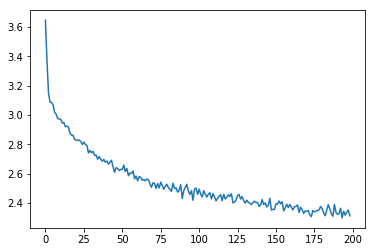

In [151]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()